/tmp/ipykernel_64713/1969567214.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor = torch.load(tensor_path).numpy()


✔️ Shape OK: (4, 166, 166), dtype=float32
✔️ Sin NaNs ni Inf

Correlation (Fisher z): min -0.688, max 2.192, mean 0.484, std 0.307
   ✔️ Correlation (Fisher z) simétrico (diff=0.00e+00)
Normalized MI: min 0.000, max 0.296, mean 0.203, std 0.019
   ✔️ Normalized MI simétrico (diff=0.00e+00)
Granger Causality: min 0.000, max 31.798, mean 1.870, std 2.116
DCV (std of corr): min 0.000, max 0.713, mean 0.319, std 0.080
   ✔️ DCV (std of corr) simétrico (diff=0.00e+00)



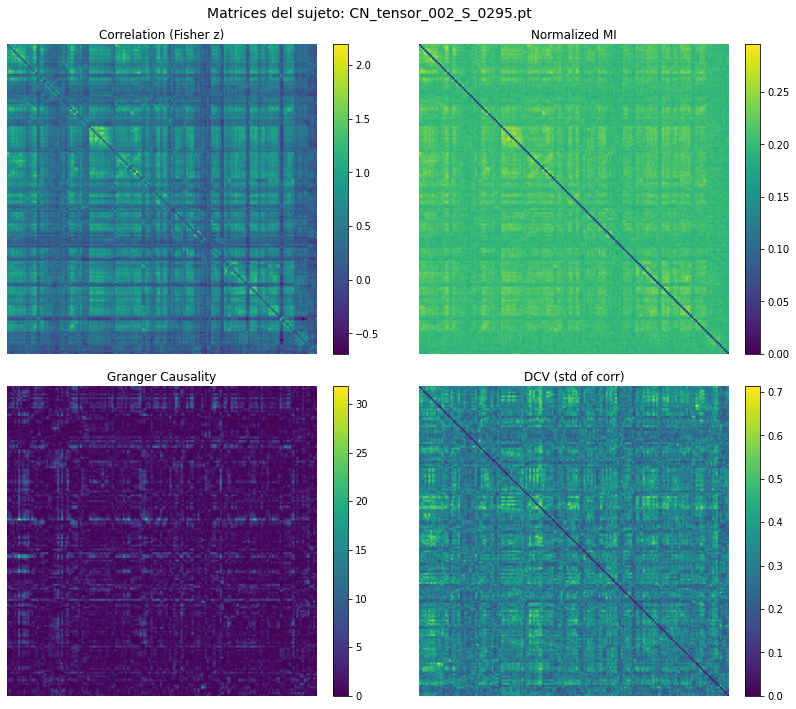

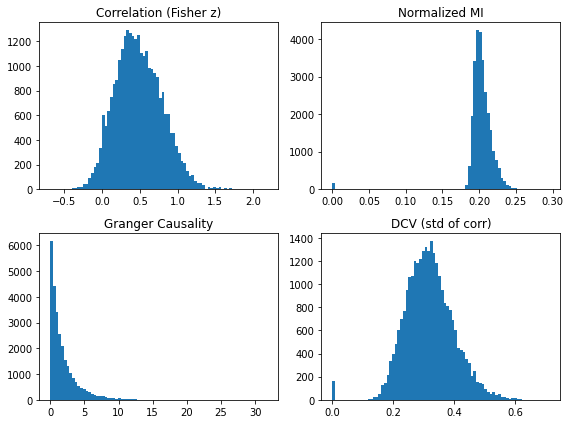

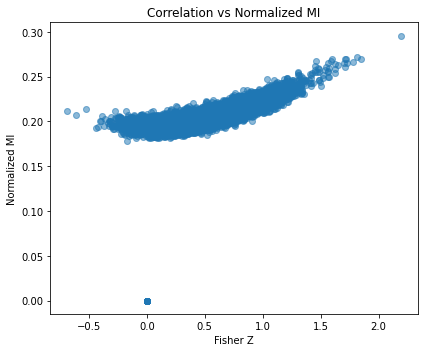

GC p<0.05: 5490/27390 = 0.200

Top 5 drivers (out-degree):
  Paracentral_Lobule_R: 120
  Vermis_9: 115
  Cerebelum_Crus1_R: 108
  Frontal_Inf_Oper_L: 94
  Insula_L: 92

Top 5 receptors (in-degree):
  Frontal_Inf_Oper_L: 97
  OFCant_R: 96
  OFCpost_R: 96
  Insula_L: 76
  Paracentral_Lobule_R: 76

DCV threshold=0.478, hubs count=808
Primeros 10 hubs mapeados a ROIs:
  (Precentral_L, Postcentral_R) -> 0.487
  (Precentral_L, SupraMarginal_R) -> 0.507
  (Precentral_L, Cerebelum_9_R) -> 0.591
  (Precentral_L, SN_pr_R) -> 0.532
  (Precentral_R, Frontal_Mid_2_L) -> 0.530
  (Precentral_R, Frontal_Inf_Oper_L) -> 0.496
  (Precentral_R, Frontal_Inf_Tri_L) -> 0.539
  (Precentral_R, Cerebelum_8_R) -> 0.486
  (Frontal_Sup_2_L, Insula_R) -> 0.494
  (Frontal_Sup_2_L, Postcentral_R) -> 0.566


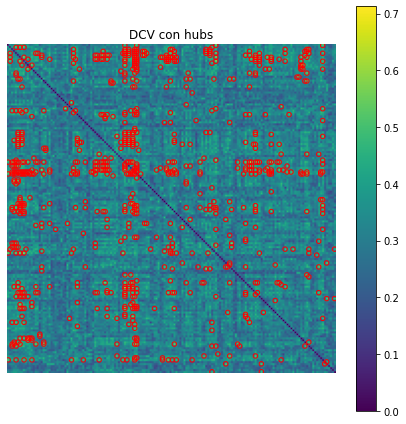


✅ Análisis completo terminado para sujeto: CN_tensor_002_S_0295.pt


In [14]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
plot_subject_matrices.py

Carga un sujeto aleatorio de TensorData y plotea:
 1. Correlation (Fisher z)
 2. Normalized Mutual Information
 3. Granger Causality
 4. Dynamic Connectivity Variance (DCV)
Además:
 - Scatter Correlation vs NMI
 - Proporción de conexiones GC significativas
 - Detección de hubs DCV mapeados a nombres de ROI
 - Cálculo de grado de nodos en GC
"""
import os
import random
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------------------------------------------
# CONFIGURACIÓN
# -------------------------------------------------------------------
base_dir   = "/home/diego/Escritorio/ALL_170"
tensor_dir = os.path.join(base_dir, "TensorData")
roi_file   = os.path.join(base_dir, "ROI_MNI_V7_vol.txt")  # Contiene nom_l en 2a columna

# -------------------------------------------------------------------
# CARGA DE NOMBRES DE ROIs
# -------------------------------------------------------------------
df_rois = pd.read_csv(roi_file, sep="\t", header=0, dtype=str)
roi_names = df_rois['nom_l'].values  # Array de longitud >=166

# -------------------------------------------------------------------
# SELECCIÓN ALEATORIA DE SUJETO
# -------------------------------------------------------------------
pt_files = [f for f in os.listdir(tensor_dir) if f.endswith('.pt')]
if not pt_files:
    raise FileNotFoundError(f"No .pt files en {tensor_dir}")
#chosen_file = random.choice(pt_files)
chosen_file = 'CN_tensor_002_S_0295.pt'
tensor_path = os.path.join(tensor_dir, chosen_file)

# -------------------------------------------------------------------
# CARGA DEL TENSOR (4 x N x N)
# -------------------------------------------------------------------
tensor = torch.load(tensor_path).numpy()
metrics = [
    'Correlation (Fisher z)',
    'Normalized MI',
    'Granger Causality',
    'DCV (std of corr)'
]

# 1) Validaciones básicas
assert tensor.ndim == 3 and tensor.shape[0] == 4 and tensor.shape[1] == tensor.shape[2]
print(f"✔️ Shape OK: {tensor.shape}, dtype={tensor.dtype}")
n_nans = np.isnan(tensor).sum(); n_inf = np.isinf(tensor).sum()
assert n_nans + n_inf == 0, "NaN/Inf detectados"
print("✔️ Sin NaNs ni Inf\n")

# Estadísticas y simetría
for idx, name in enumerate(metrics):
    mat = tensor[idx]
    print(f"{name}: min {mat.min():.3f}, max {mat.max():.3f}, mean {mat.mean():.3f}, std {mat.std():.3f}")
    if idx in [0,1,3]:
        d = np.max(np.abs(mat - mat.T))
        assert d < 1e-6, f"{name} no simétrico"
        print(f"   ✔️ {name} simétrico (diff={d:.2e})")
print()

# -------------------------------------------------------------------
# Mapas de calor
# -------------------------------------------------------------------
fig, axes = plt.subplots(2,2, figsize=(12,10))
for i, ax in enumerate(axes.flat):
    im = ax.imshow(tensor[i], cmap='viridis', aspect='equal')
    ax.set_title(metrics[i]); ax.axis('off')
    _ = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
fig.suptitle(f"Matrices del sujeto: {chosen_file}", fontsize=14, y=0.98)
plt.tight_layout(); plt.show()

# Histogramas
fig, axs = plt.subplots(2,2, figsize=(8,6))
for i, ax in enumerate(axs.flat):
    ax.hist(tensor[i].ravel(), bins=80)
    ax.set_title(metrics[i])
plt.tight_layout(); plt.show()

# -------------------------------------------------------------------
# Análisis adicional
# -------------------------------------------------------------------
# 1. Scatter Correlation vs NMI
plt.figure(figsize=(6,5))
plt.scatter(tensor[0].ravel(), tensor[1].ravel(), alpha=0.3)
plt.xlabel('Fisher Z'); plt.ylabel('Normalized MI')
plt.title('Correlation vs Normalized MI')
plt.tight_layout(); plt.show()

# 2. GC: proporción p<0.05 => -ln(p)>2.9957
gc = tensor[2]
th_gc = -np.log(0.05)
N = gc.shape[0]
off = N*N - N
count_sig = np.sum(gc > th_gc) - np.sum(np.diag(gc)>th_gc)
prop = count_sig / off
print(f"GC p<0.05: {count_sig}/{off} = {prop:.3f}\n")

# 3. Cálculo de grado de nodos en GC
g_out = np.sum(gc > th_gc, axis=1)
g_in  = np.sum(gc > th_gc, axis=0)
# Mapea índices a nombres para top 5 drivers y receptores
top5_out = np.argsort(g_out)[-5:][::-1]
top5_in  = np.argsort(g_in)[-5:][::-1]
print("Top 5 drivers (out-degree):")
for idx in top5_out:
    print(f"  {roi_names[idx]}: {g_out[idx]}")
print("\nTop 5 receptors (in-degree):")
for idx in top5_in:
    print(f"  {roi_names[idx]}: {g_in[idx]}")

# 4. DCV hubs (mean+2*std)
dcv = tensor[3]
mu, sd = dcv.mean(), dcv.std()
th_dcv = mu + 2*sd
hub_pairs = np.argwhere(dcv > th_dcv)
print(f"\nDCV threshold={th_dcv:.3f}, hubs count={len(hub_pairs)}")
print("Primeros 10 hubs mapeados a ROIs:")
for i,j in hub_pairs[:10]:
    print(f"  ({roi_names[i]}, {roi_names[j]}) -> {dcv[i,j]:.3f}")

# 5. Mapa DCV con hubs marcados
plt.figure(figsize=(6,6))
im = plt.imshow(dcv, cmap='viridis', aspect='equal')
ys,xs = hub_pairs.T
plt.scatter(xs, ys, facecolors='none', edgecolors='r', s=20)
plt.title('DCV con hubs')
plt.axis('off'); plt.colorbar(im)
plt.tight_layout(); plt.show()

print("\n✅ Análisis completo terminado para sujeto:", chosen_file)




